# 1 Import Libraries

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import zipfile

from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam  
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.applications import VGG16
from sklearn.utils.class_weight import compute_class_weight
import concurrent.futures


%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

# 2 Data Preperation 

### 2.1 Load data and prepare data for processing

In [82]:
# Set the folder path where the dataset is located
folder_path = r"C:\Users\kicki\OneDrive\Documents\ec_utbildning\deeplearning\Kod\Face_cnn\images"

### 2.2 EDA
Analyzing the data before training the model

In [84]:
# Function to count number of images in each category
def count_images(folder_path, subset):
    counts = {}
    subset_path = os.path.join(folder_path, subset)
    for expression in os.listdir(subset_path):
        expression_path = os.path.join(subset_path, expression)
        if os.path.isdir(expression_path):
            counts[expression] = len(os.listdir(expression_path))
    return counts

# Count images in train and validation sets
train_counts = count_images(folder_path, "train")
val_counts = count_images(folder_path, "validation")

print(train_counts)
print(val_counts)

{'angry': 3993, 'disgust': 10436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}
{'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


c:\Users\kicki\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\kicki\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


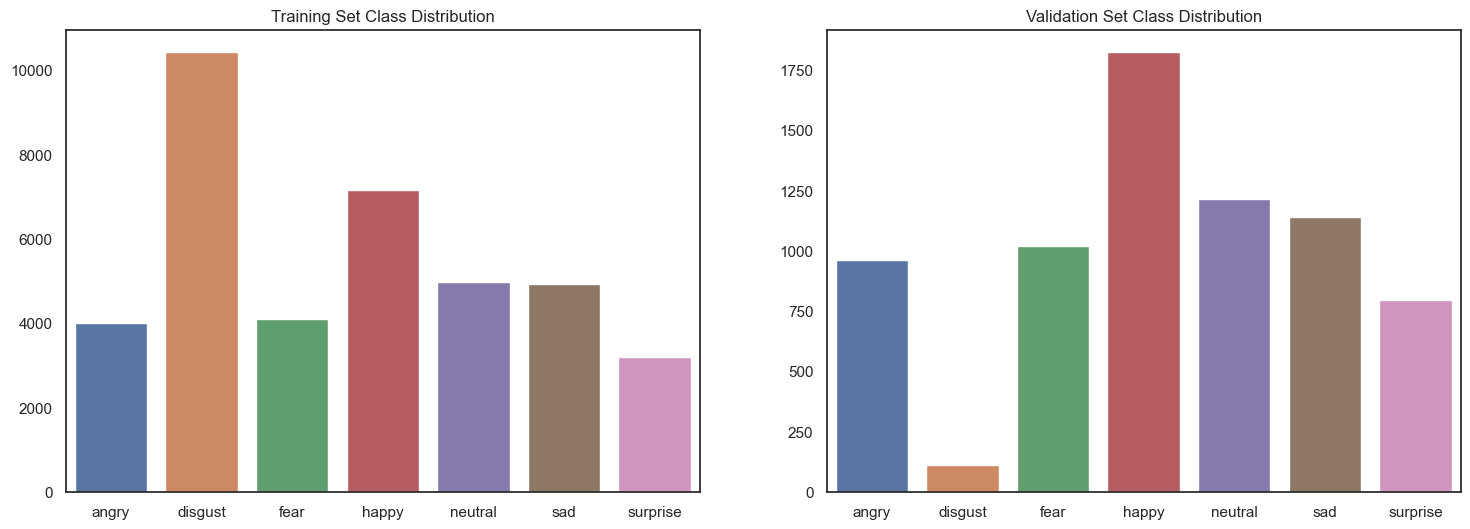

In [85]:
# Plot the distribution of classes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=axes[0])
axes[0].set_title("Training Set Class Distribution")
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()), ax=axes[1])
axes[1].set_title("Validation Set Class Distribution")
plt.show()

We have imbalanced dataset, this we will adress with data augmentation, class weights to adjust the training process so that minority classes will get more importance. 

### 2.3 Visualizing the data to get a sense of what the data from the diffrent classes looks like, checking variations in expressions and image quality

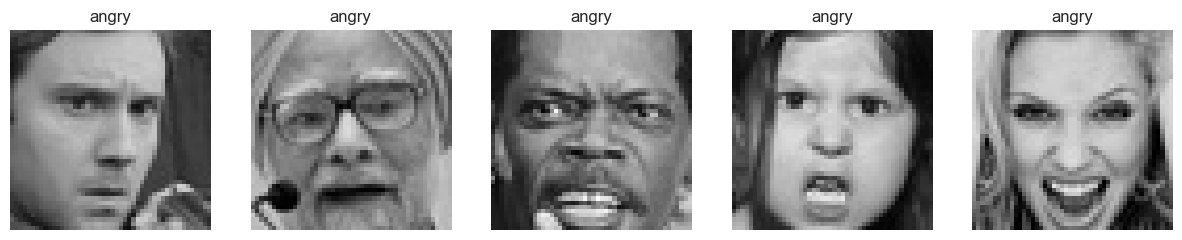

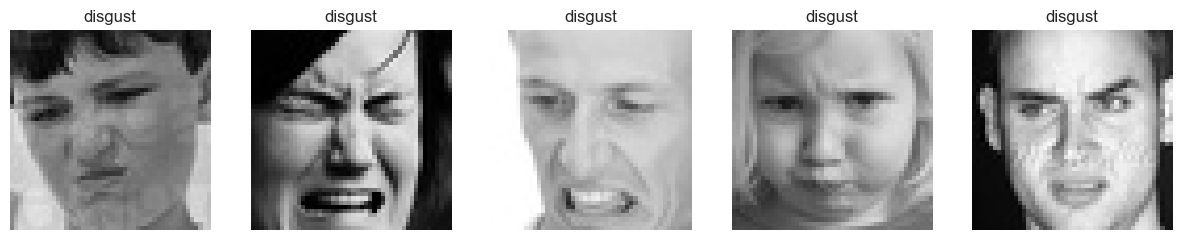

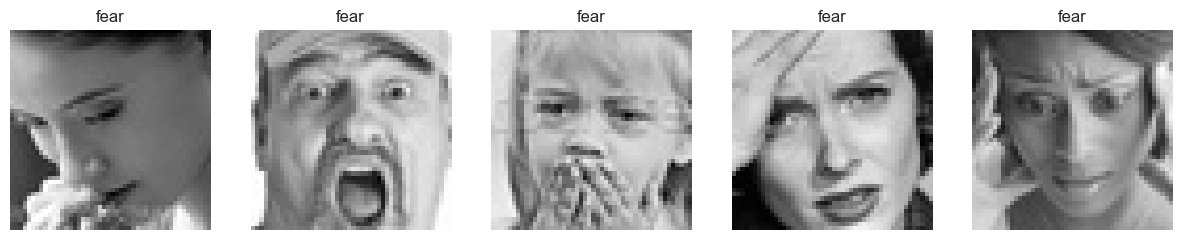

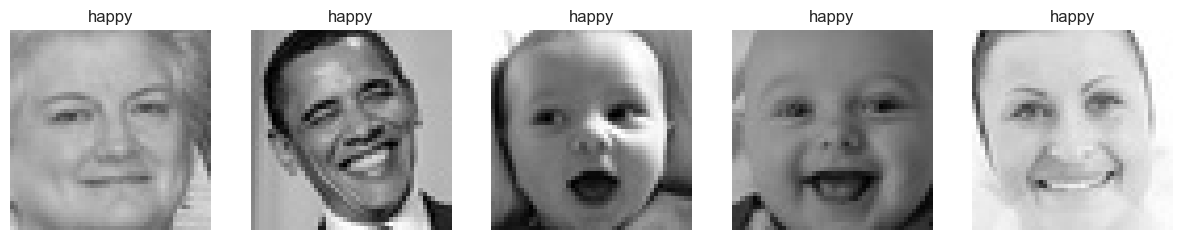

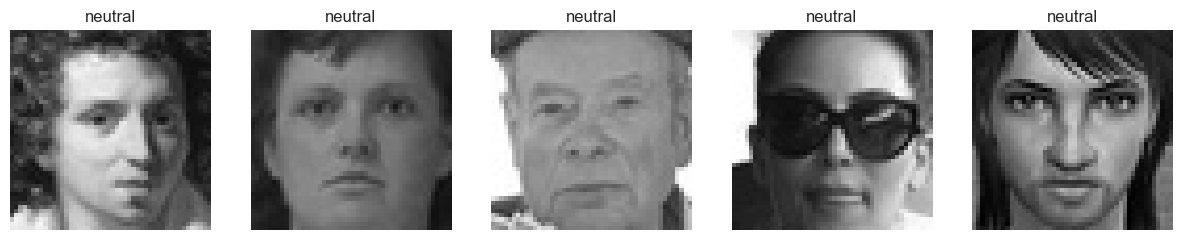

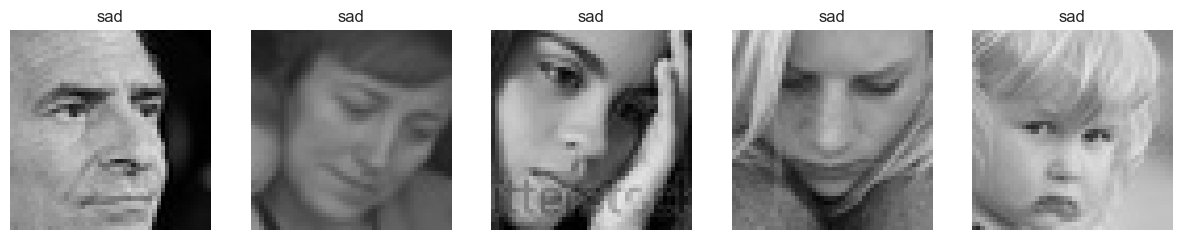

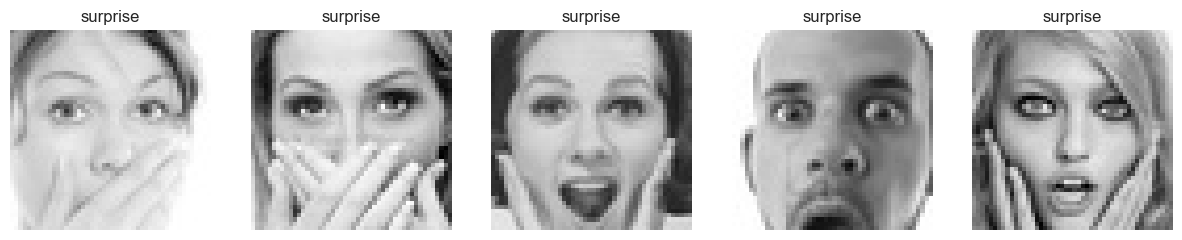

In [86]:
# Display some sample images from different classes
def display_sample_images(folder_path, subset, expression, num_images=5):
    expression_path = os.path.join(folder_path, subset, expression)
    images = os.listdir(expression_path)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        img_path = os.path.join(expression_path, img_name)
        img = load_img(img_path, target_size=(48, 48))
        plt.imshow(img, cmap='gray')
        plt.title(expression)
        plt.axis('off')
    plt.show()

for expression in train_counts.keys():
    display_sample_images(folder_path, "train", expression)

### 2.3 Data preparation
To save memory usage, we will load images in batches instead of the entire dataset and apply data augmentation

In [87]:
# Data parameters
picture_size = 48
batch_size = 32

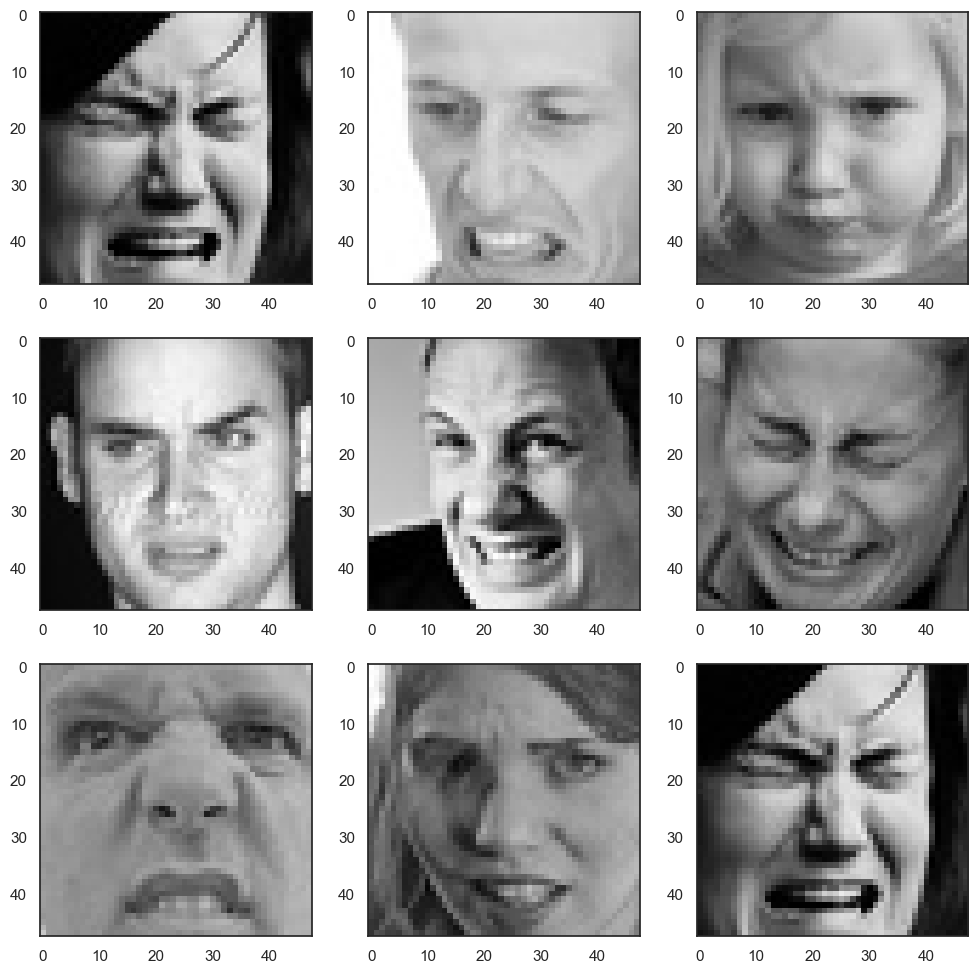

In [88]:
# Visualize some images from 'disgust' category in training set
expression = 'disgust'
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img_path = os.path.join(folder_path, "train", expression, os.listdir(os.path.join(folder_path, "train", expression))[i])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.imshow(img, cmap='gray')
plt.show()

### Data augmentation to handle imbalanced data

In [89]:
# Augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment images in a specific folder
def augment_images(img_name, folder_path, save_to_dir, augment_count):
    img_path = os.path.join(folder_path, img_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= augment_count:
            break

# Handle augmentation for all images in a folder
def augment_folder(folder_path, augment_count=100):
    save_to_dir = folder_path
    img_names = os.listdir(folder_path)
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(augment_images, img_name, folder_path, save_to_dir, augment_count) for img_name in img_names]
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            try:
                future.result()
                print(f"Completed {i + 1}/{len(img_names)}")
            except Exception as e:
                print(f"Error augmenting image: {e}")

# Augment images for the 'Disgust' class 
minority_class_path = os.path.join(folder_path, 'train', 'disgust')
augment_folder(minority_class_path)

Completed 1/10436
Completed 2/10436
Completed 3/10436
Completed 4/10436
Completed 5/10436
Completed 6/10436
Completed 7/10436
Completed 8/10436
Completed 9/10436
Completed 10/10436
Completed 11/10436
Completed 12/10436
Completed 13/10436
Completed 14/10436
Completed 15/10436
Completed 16/10436
Completed 17/10436
Completed 18/10436
Completed 19/10436
Completed 20/10436
Completed 21/10436
Completed 22/10436
Completed 23/10436
Completed 24/10436
Completed 25/10436
Completed 26/10436
Completed 27/10436
Completed 28/10436
Completed 29/10436
Completed 30/10436
Completed 31/10436
Completed 32/10436
Completed 33/10436
Completed 34/10436
Completed 35/10436
Completed 36/10436
Completed 37/10436
Completed 38/10436
Completed 39/10436
Completed 40/10436
Completed 41/10436
Completed 42/10436
Completed 43/10436
Completed 44/10436
Completed 45/10436
Completed 46/10436
Completed 47/10436
Completed 48/10436
Completed 49/10436
Completed 50/10436
Completed 51/10436
Completed 52/10436
Completed 53/10436
Co

### Verifying the result after the augmentation 

Number of images in the 'disgust' class after augmentation: 10436


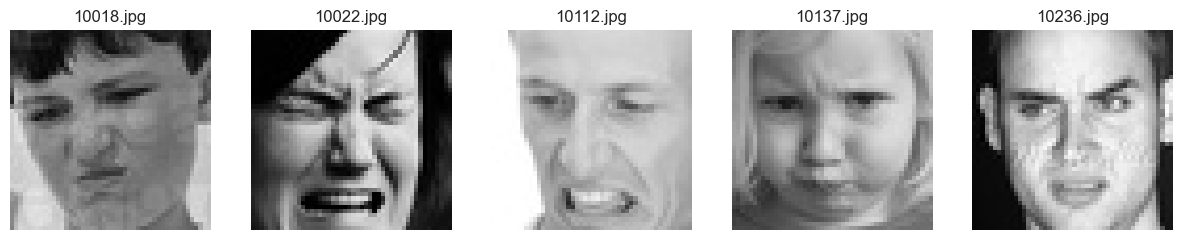

In [90]:
# Count the number of images in a folder
def count_images(folder_path):
    return len(os.listdir(folder_path))

# Count the number of images after augmentation
num_images = count_images(minority_class_path)
print(f"Number of images in the 'disgust' class after augmentation: {num_images}")

# Display sample images from a folder
def display_sample_images(folder_path, num_images=5):
    images = os.listdir(folder_path)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path, target_size=(48, 48))
        plt.imshow(img, cmap='gray')
        plt.title(img_name)
        plt.axis('off')
    plt.show()

# Display sample augmented images
display_sample_images(minority_class_path)

In [91]:
# Set up data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(
    os.path.join(folder_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_set = datagen_val.flow_from_directory(
    os.path.join(folder_path, "validation"),
    target_size=(picture_size, picture_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 38821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### Class Weights

In [94]:
# Set class weights
train_labels = train_set.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# 3. Build Model

### 3.1 Define the model

We will add the activation function after BatchNormalization to stablize and speed up training 

In [95]:
# Build model using VGG16
no_of_classes = 7
input_shape = (picture_size, picture_size, 3)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(no_of_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### 3.2 Callbacks & Training the Model
Setting up models checkpoints, early stopping and learning rate reduction on plateau to enhance training.

Fit the model using training and validation data generators with specified callbacks

In [96]:
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

# Callbacks
checkpoint = ModelCheckpoint("./model_vgg16_with_more_layers_lr_schedule.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=5,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate, lr_schedule]

# Train the model
history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=50,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    class_weight=class_weights,
    callbacks=callbacks_list
)

# Unfreeze layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=50,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    class_weight=class_weights,
    callbacks=callbacks_list
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
1213/1213 [==============================] - ETA: 0s - loss: 1.6309 - accuracy: 0.4052
Epoch 1: val_accuracy improved from -inf to 0.31747, saving model to .\model_vgg16_with_more_layers_lr_schedule.h5
1213/1213 [==============================] - 100s 82ms/step - loss: 1.6309 - accuracy: 0.4052 - val_loss: 1.7307 - val_accuracy: 0.3175 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/50
1213/1213 [==============================] - ETA: 0s - loss: 1.5156 - accuracy: 0.4468
Epoch 2: val_accuracy improved from 0.31747 to 0.32642, saving model to .\model_vgg16_with_more_layers_lr_schedule.h5
1213/1213 [==============================] - 45s 37ms/step - loss: 1.5156 - accuracy: 0.4468 - val_loss: 1.7010 - val_accuracy: 0.3264 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/50
1213/1213 [====

# 4 Evaulate the model
Evaluating the model with Accuracy and loss

In [97]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_set, steps=test_set.n // test_set.batch_size)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

220/220 [==============================] - 3s 16ms/step - loss: 0.9904 - accuracy: 0.6382
Test Loss: 0.9903513193130493
Test Accuracy: 0.6382102370262146


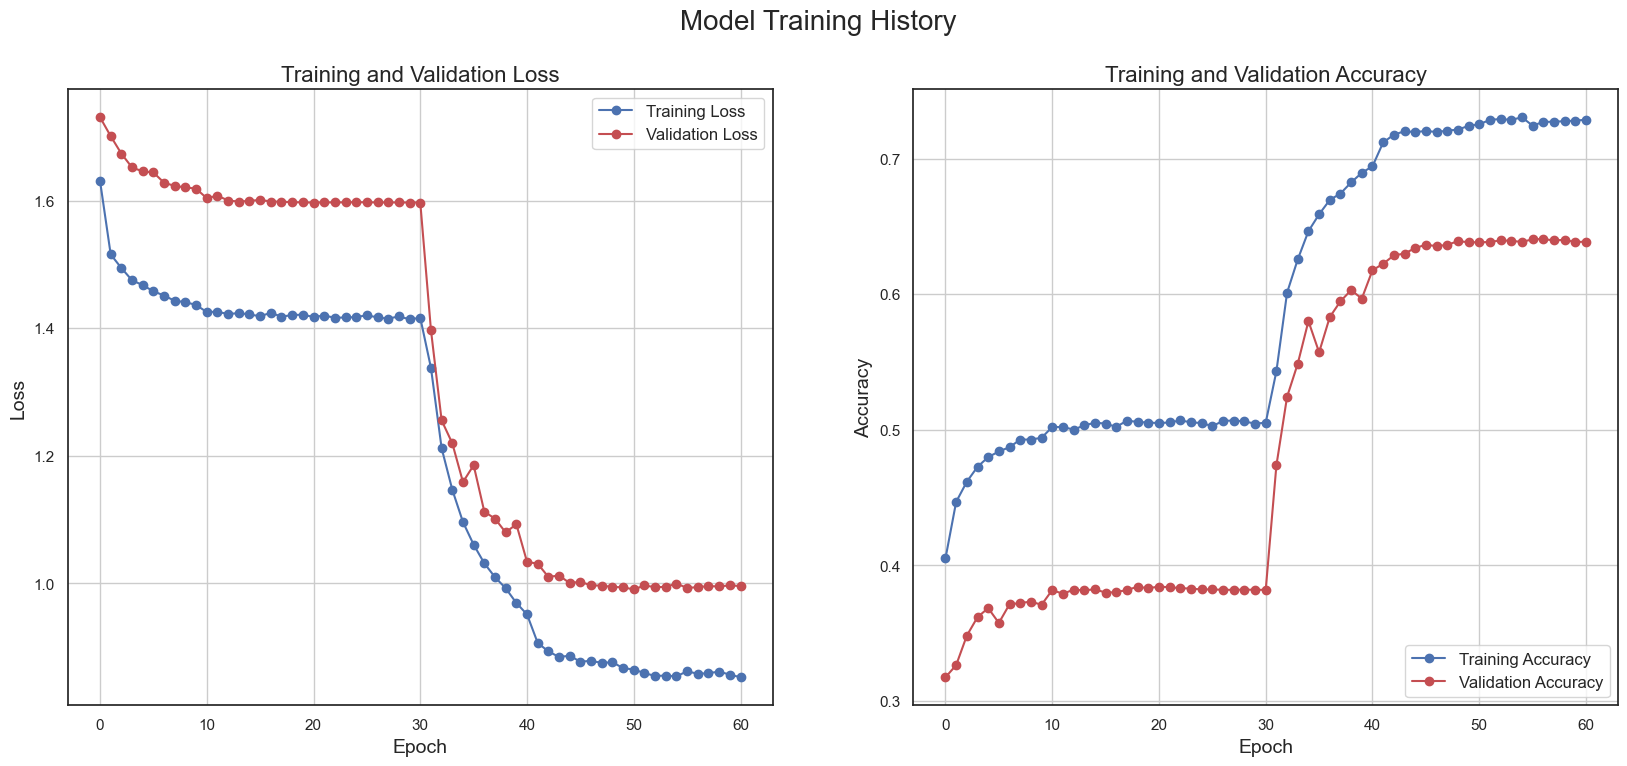

In [98]:
# Define a function to plot training history
def plot_training_history(history, history_fine):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Combine history
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    accuracy = history.history['accuracy'] + history_fine.history['accuracy']
    val_accuracy = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    
    # Plot loss
    ax1.plot(loss, label='Training Loss', color='b', marker='o')
    ax1.plot(val_loss, label='Validation Loss', color='r', marker='o')
    ax1.set_title('Training and Validation Loss', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(loc='upper right', fontsize=12)
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(accuracy, label='Training Accuracy', color='b', marker='o')
    ax2.plot(val_accuracy, label='Validation Accuracy', color='r', marker='o')
    ax2.set_title('Training and Validation Accuracy', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid(True)
    
    plt.suptitle('Model Training History', fontsize=20)
    plt.show()

# Plot the training history
plot_training_history(history, history_fine)

# Save model

In [101]:
# Save the final model
model.save('final_model_vgg16_with_more_layers.h5')